In [29]:
import ast
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras import layers
from scikeras.wrappers import KerasClassifier, KerasRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc


# Import

In [2]:
df = pd.read_csv("./moviesRatings/merged_dfs.csv")
df

,userId,rating,adult,budget,genres,id,imdb_id,original_language,overview,popularity,...,production_countries_name,spoken_languages_name,production_companies_name,genre_name,director,cast,keywords,keywords_id,movie_title,average_sentiment
0,229,4.0,True,21000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",858,tt0108160,en,A young boy who tries to set his dad up on a d...,10.234919,...,['US'],['en'],['TriStar Pictures'],"['Comedy', 'Drama', 'Romance']",['Nora Ephron'],"['Tom Hanks', 'Meg Ryan', 'Bill Pullman', 'Ros...","[{'id': 494, 'name': 'father son relationship'...","[494, 725, 736, 936, 1014, 1224, 1441, 2038, 2...",Sleepless in Seattle,0.179658
1,741,4.5,True,21000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",858,tt0108160,en,A young boy who tries to set his dad up on a d...,10.234919,...,['US'],['en'],['TriStar Pictures'],"['Comedy', 'Drama', 'Romance']",['Nora Ephron'],"['Tom Hanks', 'Meg Ryan', 'Bill Pullman', 'Ros...","[{'id': 494, 'name': 'father son relationship'...","[494, 725, 736, 936, 1014, 1224, 1441, 2038, 2...",Sleepless in Seattle,0.179658
2,1846,4.0,True,21000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",858,tt0108160,en,A young boy who tries to set his dad up on a d...,10.234919,...,['US'],['en'],['TriStar Pictures'],"['Comedy', 'Drama', 'Romance']",['Nora Ephron'],"['Tom Hanks', 'Meg Ryan', 'Bill Pullman', 'Ros...","[{'id': 494, 'name': 'father son relationship'...","[494, 725, 736, 936, 1014, 1224, 1441, 2038, 2...",Sleepless in Seattle,0.179658
3,1932,4.5,True,21000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",858,tt0108160,en,A young boy who tries to set his dad up on a d...,10.234919,...,['US'],['en'],['TriStar Pictures'],"['Comedy', 'Drama', 'Romance']",['Nora Ephron'],"['Tom Hanks', 'Meg Ryan', 'Bill Pullman', 'Ros...","[{'id': 494, 'name': 'father son relationship'...","[494, 725, 736, 936, 1014, 1224, 1441, 2038, 2...",Sleepless in Seattle,0.179658
4,2520,4.5,True,21000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",858,tt0108160,en,A young boy who tries to set his dad up on a d...,10.234919,...,['US'],['en'],['TriStar Pictures'],"['Comedy', 'Drama', 'Romance']",['Nora Ephron'],"['Tom Hanks', 'Meg Ryan', 'Bill Pullman', 'Ros...","[{'id': 494, 'name': 'father son relationship'...","[494, 725, 736, 936, 1014, 1224, 1441, 2038, 2...",Sleepless in Seattle,0.179658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595873,270123,2.5,True,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",87587,tt1691154,en,Worried that he has gotten the free-spirited M...,1.786580,...,[],['en'],[],"['Comedy', 'Drama', 'Romance']",['J.C. Khoury'],"['Noah Bean', 'Rachel Boston', 'Anna Chlumsky'...","[{'id': 13149, 'name': 'pregnancy'}]",[13149],The Pill,0.064886
595874,267597,3.5,True,0,"[{'id': 80, 'name': 'Crime'}, {'id': 53, 'name...",136850,tt1510686,en,A naive college student loses a scholarship at...,2.142248,...,['US'],['en'],['Myriad Pictures'],"['Crime', 'Thriller']",['Jamie Babbit'],"['Shawn Ashmore', 'Madeline Zima', 'Agnes Bruc...","[{'id': 10768, 'name': 'lesbian'}, {'id': 1870...","[10768, 187056, 208508]",Breaking the Girls,0.065313
595875,270123,3.0,True,0,"[{'id': 80, 'name': 'Crime'}, {'id': 18, 'name...",116746,tt0016201,en,Armand and Marie survive in the streets until ...,0.001396,...,['US'],['en'],[],"['Crime', 'Drama', 'Romance']",['Louis J. Gasnier'],"['Clara Bow', 'Donald Keith', 'Lillian Leighto...","[{'id': 154802, 'name': 'silent film'}]",[154802],Parisian Love,0.101852
595876,270123,3.0,True,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",140222,tt1976989,en,When a young soldier in Vietnam gets dumped by...,6.617821,...,['US'],['en'],"['Deep Blue Pictures', 'Red 56']","['Drama', 'Romance', 'War']",['Danny Mooney '],"['Liam Hemsworth', 'Teresa Palmer', 'Aimee Tee...","[{'id': 2957, 'name': 'vietnam war'}, {'id': 3...","[2957, 33564, 165431, 169123, 222811]",Love and Honor,0.263733


## from string to literal

In [3]:
for col in ["genre_name", "production_countries_name", "spoken_languages_name", "production_companies_name", "director", "cast", "keywords_id"]:
    print(col)
    df[col] = df[col].apply(ast.literal_eval)

genre_name
production_countries_name
spoken_languages_name
production_companies_name
director
cast
keywords_id


In [4]:
def bool_to_binary(b):
    return 1 if b else 0
df["adult"] = df["adult"].apply(bool_to_binary)

In [5]:
df["release_year"] = pd.to_datetime(df["release_date"]).dt.year

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595878 entries, 0 to 595877
Data columns (total 31 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   userId                     595878 non-null  int64  
 1   rating                     595878 non-null  float64
 2   adult                      595878 non-null  int64  
 3   budget                     595878 non-null  int64  
 4   genres                     595878 non-null  object 
 5   id                         595878 non-null  int64  
 6   imdb_id                    595878 non-null  object 
 7   original_language          595868 non-null  object 
 8   overview                   593026 non-null  object 
 9   popularity                 595878 non-null  float64
 10  production_companies       595878 non-null  object 
 11  production_countries       595878 non-null  object 
 12  release_date               595878 non-null  object 
 13  revenue                    59

## remove unecessary columns
for the sake of being neat

In [7]:
cols_to_drop = ["genres", "imdb_id", "production_companies", "production_countries", "spoken_languages", "keywords", "release_date"]
df = df.drop(columns=cols_to_drop)
df

,userId,rating,adult,budget,id,original_language,overview,popularity,revenue,runtime,...,production_countries_name,spoken_languages_name,production_companies_name,genre_name,director,cast,keywords_id,movie_title,average_sentiment,release_year
0,229,4.0,1,21000000,858,en,A young boy who tries to set his dad up on a d...,10.234919,227799884.0,105.0,...,[US],[en],[TriStar Pictures],"[Comedy, Drama, Romance]",[Nora Ephron],"[Tom Hanks, Meg Ryan, Bill Pullman, Ross Malin...","[494, 725, 736, 936, 1014, 1224, 1441, 2038, 2...",Sleepless in Seattle,0.179658,1993
1,741,4.5,1,21000000,858,en,A young boy who tries to set his dad up on a d...,10.234919,227799884.0,105.0,...,[US],[en],[TriStar Pictures],"[Comedy, Drama, Romance]",[Nora Ephron],"[Tom Hanks, Meg Ryan, Bill Pullman, Ross Malin...","[494, 725, 736, 936, 1014, 1224, 1441, 2038, 2...",Sleepless in Seattle,0.179658,1993
2,1846,4.0,1,21000000,858,en,A young boy who tries to set his dad up on a d...,10.234919,227799884.0,105.0,...,[US],[en],[TriStar Pictures],"[Comedy, Drama, Romance]",[Nora Ephron],"[Tom Hanks, Meg Ryan, Bill Pullman, Ross Malin...","[494, 725, 736, 936, 1014, 1224, 1441, 2038, 2...",Sleepless in Seattle,0.179658,1993
3,1932,4.5,1,21000000,858,en,A young boy who tries to set his dad up on a d...,10.234919,227799884.0,105.0,...,[US],[en],[TriStar Pictures],"[Comedy, Drama, Romance]",[Nora Ephron],"[Tom Hanks, Meg Ryan, Bill Pullman, Ross Malin...","[494, 725, 736, 936, 1014, 1224, 1441, 2038, 2...",Sleepless in Seattle,0.179658,1993
4,2520,4.5,1,21000000,858,en,A young boy who tries to set his dad up on a d...,10.234919,227799884.0,105.0,...,[US],[en],[TriStar Pictures],"[Comedy, Drama, Romance]",[Nora Ephron],"[Tom Hanks, Meg Ryan, Bill Pullman, Ross Malin...","[494, 725, 736, 936, 1014, 1224, 1441, 2038, 2...",Sleepless in Seattle,0.179658,1993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595873,270123,2.5,1,0,87587,en,Worried that he has gotten the free-spirited M...,1.786580,0.0,83.0,...,[],[en],[],"[Comedy, Drama, Romance]",[J.C. Khoury],"[Noah Bean, Rachel Boston, Anna Chlumsky, Jean...",[13149],The Pill,0.064886,2011
595874,267597,3.5,1,0,136850,en,A naive college student loses a scholarship at...,2.142248,0.0,83.0,...,[US],[en],[Myriad Pictures],"[Crime, Thriller]",[Jamie Babbit],"[Shawn Ashmore, Madeline Zima, Agnes Bruckner,...","[10768, 187056, 208508]",Breaking the Girls,0.065313,2013
595875,270123,3.0,1,0,116746,en,Armand and Marie survive in the streets until ...,0.001396,0.0,70.0,...,[US],[en],[],"[Crime, Drama, Romance]",[Louis J. Gasnier],"[Clara Bow, Donald Keith, Lillian Leighton, J....",[154802],Parisian Love,0.101852,1925
595876,270123,3.0,1,0,140222,en,When a young soldier in Vietnam gets dumped by...,6.617821,0.0,92.0,...,[US],[en],"[Deep Blue Pictures, Red 56]","[Drama, Romance, War]",[Danny Mooney ],"[Liam Hemsworth, Teresa Palmer, Aimee Teegarde...","[2957, 33564, 165431, 169123, 222811]",Love and Honor,0.263733,2013


# Choose 1 user

In [8]:
df["userId"].value_counts()

userId
45811     2203
8659      2106
179792    1826
107720    1587
229879    1416
          ... 
125345     320
62489      317
255904     315
259328     313
123882     306
Name: count, Length: 1190, dtype: int64

In [9]:
oneDs = df[df["userId"] == 45811].reset_index(drop=True)
oneDs['likeMovie'] = oneDs['rating'] >= 4
oneDs

,userId,rating,adult,budget,id,original_language,overview,popularity,revenue,runtime,...,spoken_languages_name,production_companies_name,genre_name,director,cast,keywords_id,movie_title,average_sentiment,release_year,likeMovie
0,45811,4.5,1,21000000,858,en,A young boy who tries to set his dad up on a d...,10.234919,227799884.0,105.0,...,[en],[TriStar Pictures],"[Comedy, Drama, Romance]",[Nora Ephron],"[Tom Hanks, Meg Ryan, Bill Pullman, Ross Malin...","[494, 725, 736, 936, 1014, 1224, 1441, 2038, 2...",Sleepless in Seattle,0.179658,1993,True
1,45811,4.0,1,24000000,1246,en,When he loses a highly publicized virtual boxi...,11.697604,155721132.0,102.0,...,"[en, es]","[Columbia Pictures, Revolution Studios, Rogue ...",[Drama],[Sylvester Stallone],"[Sylvester Stallone, Burt Young, Milo Ventimig...","[276, 396, 1721, 2038, 2416, 2792, 2968, 3393,...",Rocky Balboa,0.161213,2006,True
2,45811,3.5,1,0,1968,en,Alex Whitman (Matthew Perry) is a designer fro...,6.285574,29481428.0,109.0,...,[en],[Columbia Pictures],"[Drama, Comedy, Romance]",[Andy Tennant],"[Matthew Perry, Salma Hayek, Jon Tenney, Siobh...","[828, 1463, 9799, 13149]",Fools Rush In,0.063483,1997,False
3,45811,4.0,1,0,2762,en,Derrick De Marney finds himself in a 39 Steps ...,3.824884,0.0,83.0,...,[en],[Gaumont British Picture Corporation],"[Drama, Crime]",[Alfred Hitchcock],"[Nova Pilbeam, Derrick De Marney, Percy Marmon...","[769, 1655, 9826, 9937]",Young and Innocent,0.087360,1937,True
4,45811,3.5,1,35000000,2959,en,"Newly engaged, Ben and Sadie can't wait to sta...",7.102076,69307224.0,91.0,...,[en],"[Village Roadshow Pictures, Robert Simonds Pro...",[Comedy],[Ken Kwapis],"[Robin Williams, Mandy Moore, John Krasinski, ...","[1605, 2856, 3582, 3583, 6038, 6192, 6281, 670...",License to Wed,0.072975,2007,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2198,45811,4.0,1,0,171363,en,Five suspects holding a piece of the truth beh...,1.058620,0.0,78.0,...,[en],[Antena Latina Films],"[Action, Thriller, Crime]",[Alfonso Rodríguez],"[Ving Rhames, Steven Bauer, Kristen Quintrall,...","[2708, 9826, 179385]",Pimp Bullies,0.000000,2011,True
2199,45811,0.5,1,0,172847,en,"Stranded on an isolated desert road, two life-...",5.471865,0.0,85.0,...,[en],"[Anonymous Content, Best Medicine Productions]","[Drama, Thriller]","[Kevin Goetz, Michael Goetz]","[Josh Duhamel, Dan Fogler, Miracle Laurie, Chr...","[6241, 9713, 13088, 14955, 18034, 202692, 220608]",Scenic Route,0.292698,2013,False
2200,45811,3.0,1,0,173491,en,What is home? And how do we find it? TINY foll...,0.877716,0.0,62.0,...,[en],[Speak Thunder Films],[Documentary],"[Christopher Smith, Merete Mueller]","[Daryl Gibson, Christopher Smith, Paul H. Smit...",[187056],TINY: A Story About Living Small,0.172345,2013,False
2201,45811,3.0,1,0,174195,en,"After being punched in the nose, Sach finds ou...",0.158484,0.0,64.0,...,[en],[Monogram Pictures],[Comedy],[Edward Bernds],"[Leo Gorcey, Huntz Hall, Bernard Gorcey, Rober...",[190483],Private Eyes,0.120140,1953,False


In [10]:
# oneDs.to_csv("oneDs.csv", index=False)

# Dummies for Categorical variables

In [11]:
oneDs_selected_dummies = oneDs.copy()

def get_top_1pc_freq_dummies(oneDs_selected_dummies: pd.DataFrame, cols: list, prefixes: dict) -> pd.DataFrame:
    for col in cols:
        # counting frequency of each category for this user
        value_counts = oneDs_selected_dummies.explode(col)[col].value_counts().sort_values(ascending=False).reset_index(name="count")

        num_cats = len(value_counts)
        match col:
            case "production_countries_name":
                # value_counts['count_cumulative_pc'] = (value_counts["count"].cumsum() / value_counts["count"].sum()) * 100
                # values_to_remove = value_counts[value_counts["count_cumulative_pc"] > 90][col]
                values_to_remove = value_counts.iloc[int(len(value_counts) * 0.2):, :][col]
            case "spoken_languages_name":
                # value_counts['count_cumulative_pc'] = (value_counts["count"].cumsum() / value_counts["count"].sum()) * 100
                # values_to_remove = value_counts[value_counts["count_cumulative_pc"] > 90][col]
                values_to_remove = value_counts.iloc[int(len(value_counts) * 0.2):, :][col]
            case "production_companies_name":
                values_to_remove = value_counts[int(num_cats * 0.01):][col] 
            case "keywords_id":
                # get a list of values (categories) to remove (only keep top 1%)
                values_to_remove = value_counts[int(num_cats * 0.01):][col] 

        # get dummies for all categories
        mlb = MultiLabelBinarizer()
        OHE = mlb.fit_transform(oneDs_selected_dummies[col])
        OHE = pd.DataFrame(OHE)
        prefix = prefixes[col]
        prefixed_strings = list(map(lambda s: prefix + str(s), mlb.classes_))
        OHE.columns = prefixed_strings
        oneDs_selected_dummies = pd.concat([oneDs_selected_dummies.reset_index(drop=True), OHE], axis=1)

        # remove categories with low frequency
        oneDs_selected_dummies = oneDs_selected_dummies.drop(columns=[f"{prefix}{v}" for v in values_to_remove])

        # remove original column
        oneDs_selected_dummies = oneDs_selected_dummies.drop(columns=[col])
    

    return oneDs_selected_dummies

oneDs_selected_dummies = get_top_1pc_freq_dummies(oneDs_selected_dummies, 
                         cols=['production_countries_name',
                               'spoken_languages_name',
                               'production_companies_name',
                               'keywords_id'],
                         prefixes={'production_countries_name': "ProdCountry_",
                                   'spoken_languages_name': "SpokenLang_",
                                   'production_companies_name': "ProdCompany_",
                                   'keywords_id': "kw_"})

# get dummies for all genres
mlb = MultiLabelBinarizer()
OHE = mlb.fit_transform(oneDs_selected_dummies["genre_name"])
OHE = pd.DataFrame(OHE)
prefix = "Genre_"
prefixed_strings = list(map(lambda s: prefix + str(s), mlb.classes_))
OHE.columns = prefixed_strings
oneDs_selected_dummies = pd.concat([oneDs_selected_dummies.reset_index(drop=True), OHE], axis=1)

oneDs_selected_dummies = oneDs_selected_dummies.drop(columns=["genre_name"])
print(oneDs_selected_dummies.shape)

(2203, 136)


In [12]:
X = oneDs_selected_dummies.drop(columns=["userId", "id", "rating", "likeMovie", "original_language", "overview", "tagline", "title", \
    "director", "cast", "movie_title"])
y = oneDs_selected_dummies["likeMovie"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

# Sequential Model

## Train Test Split and Scaling

In [36]:
X = oneDs_selected_dummies.drop(columns=["userId", "id", "rating", "likeMovie", "original_language", "overview", "tagline", "title", \
    "director", "cast", "movie_title", "budget", "popularity", "average_sentiment"])
y = oneDs_selected_dummies["likeMovie"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

In [37]:
num_features = X_train_scaled.shape[1]
print(f"num of features = {num_features}")

num of features = 122


In [38]:
def confusion_matrix_plot(cm):
    fig, ax = plt.subplots(figsize=(3,3))
    ax.imshow(cm)
    ax.grid(False)
    ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
    ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
    ax.set_ylim(1.5, -0.5)
    for i in range(2):
        for j in range(2):
            ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
    plt.show()

def roc_plot(y, y_pred):
    # Calculate the false positive rate, true positive rate, and thresholds
    fpr, tpr, thresholds = roc_curve(y, y_pred)

    # Calculate the area under the ROC curve
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

## Fit model

In [39]:
# model = keras.Sequential()
# model.add(keras.Input((num_features,)))
# # model.add(layers.Dense(num_features, activation="relu", name="layer1"))
# model.add(layers.Dense(60, activation="relu", name="layer2"))
# model.add(layers.Dense(25, activation="relu", name="layer3"))
# model.add(layers.Dense(1, activation="sigmoid", name="output_layer"))

In [40]:
# model.compile(loss="binary_crossentropy", optimizer="sgd", metrics=["F1Score"])
# model.fit(X_train_scaled, y_train, epochs=100)

## GridSearchCV without sampling

In [41]:
# import warnings 
# warnings.filterwarnings("ignore")

# # Define a function to create the neural network model
# def create_model():
#     model = keras.Sequential([
#         keras.Input((num_features,)),
#         layers.Dense(64, activation="relu"),
#         layers.Dense(1, activation='sigmoid')
#     ])
#     # model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['F1Score'])
#     return model

# # Create a KerasClassifier based on the create_model function
# model = KerasClassifier(build_fn=create_model, loss="binary_crossentropy", verbose=0, random_state=42)

# param_grid = {
#     'optimizer': ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam'],
#     'epochs': [25, 50, 75, 100], 
#     'batch_size': [32, 64]
# }

# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='f1_macro')
# grid_search.fit(X_train_scaled, y_train)

# # Get the best model and its hyperparameters
# best_model = grid_search.best_estimator_
# best_params = grid_search.best_params_

# # Print the best parameters and best cross-validation score
# print('Best Parameters:', best_params)
# print('Best F1 macro:', grid_search.best_score_)


# ###################################### Get confusion matrix of training results ######################################
# y_train_pred = np.round(best_model.predict(X_train_scaled))

# # Calculate classification metrics
# accuracy = accuracy_score(y_train, y_train_pred)
# f1_macro = f1_score(y_train, y_train_pred, average='macro')
# roc_auc = roc_auc_score(y_train, y_train_pred)

# print("=== Classification Results for Training Set ===")
# # print(f"Accuracy: {accuracy:.2f}")
# # print(f"F1 Score (Macro): {f1_macro:.2f}")
# print(classification_report(y_train, y_train_pred))
# print(f"Area under ROC Curve (TP/FP): {roc_auc:.2f}")

# cm = confusion_matrix(y_train, y_train_pred)
# confusion_matrix_plot(cm)

### Evaluation

In [42]:
# ###################################### Get confusion matrix of test results ######################################
# y_test_pred = np.round(best_model.predict(X_test_scaled))

# # Calculate classification metrics
# accuracy = accuracy_score(y_test, y_test_pred)
# f1_macro = f1_score(y_test, y_test_pred, average='macro')
# roc_auc = roc_auc_score(y_test, y_test_pred)

# print("=== Classification Results for Test Set ===")
# # print(f"Accuracy: {accuracy:.2f}")
# # print(f"F1 Score (Macro): {f1_macro:.2f}")
# print(classification_report(y_test, y_test_pred))
# print(f"Area under ROC Curve (TP/FP): {roc_auc:.2f}")

# cm = confusion_matrix(y_test, y_test_pred)
# confusion_matrix_plot(cm)


so far best_model:
``` python
def create_model():
    model = keras.Sequential([
        keras.Input((num_features,)),
        layers.Dense(64, activation="relu"),
        layers.Dense(1, activation='sigmoid')
    ])
    # model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['F1Score'])
    return model

# Create a KerasClassifier based on the create_model function
model = KerasClassifier(build_fn=create_model, loss="binary_crossentropy", verbose=0, random_state=42)

param_grid = {
    'optimizer': ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam'],
    'epochs': [25, 50, 75, 100], 
    'batch_size': [32, 64]
}
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='f1_macro')

Best Parameters: {'batch_size': 32, 'epochs': 100, 'optimizer': 'Nadam'}
Best F1 macro: 0.6671255732963636

=== Classification Results for Test Set ===
              precision    recall  f1-score   support

       False       0.79      0.86      0.83       313
        True       0.57      0.45      0.51       128

    accuracy                           0.74       441
   macro avg       0.68      0.66      0.67       441
weighted avg       0.73      0.74      0.73       441

Area under ROC Curve (TP/FP): 0.66

```

## GridSearchCV, undersample majority class

In [43]:
# from y_train = False, sample same number of data points as y_train = True (ensure balanced classes)
majority_class_sampled_indices = random.sample(list(y_train[y_train == False].index), k=len(y_train[y_train == True]))
sample_indices = list(majority_class_sampled_indices) + list(y_train[y_train == True].index) # undersampled majority class + all of minority class
X_train_scaled_sampled = X_train_scaled[X_train_scaled.index.isin(list(sample_indices))]
y_train_sampled = y_train[y_train.index.isin(list(sample_indices))]

Best Parameters: {'batch_size': 64, 'epochs': 150, 'optimizer': 'Nadam'}
Best F1 macro: 0.6579008073817764
=== Classification Results for Training Set ===
              precision    recall  f1-score   support

       False       0.99      0.99      0.99       510
        True       0.99      0.99      0.99       510

    accuracy                           0.99      1020
   macro avg       0.99      0.99      0.99      1020
weighted avg       0.99      0.99      0.99      1020

Area under ROC Curve (TP/FP): 0.99


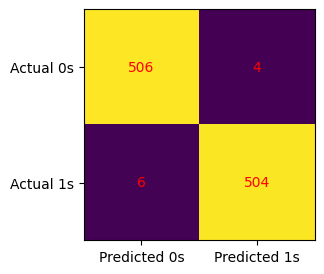

In [46]:
import warnings 
warnings.filterwarnings("ignore")

# Define a function to create the neural network model
def create_model():
    model = keras.Sequential([
        keras.Input((num_features,)),
        layers.Dense(45, activation="relu"),
        layers.Dense(1, activation='sigmoid')
    ])
    # model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['F1Score'])
    return model

# Create a KerasClassifier based on the create_model function
model = KerasClassifier(build_fn=create_model, loss="binary_crossentropy", verbose=0, random_state=42)

param_grid = {
    'optimizer': ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam'], # 
    'epochs': [100, 125, 150],  #  
    'batch_size': [32, 64]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train_scaled_sampled, y_train_sampled)

# Get the best model and its hyperparameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Print the best parameters and best cross-validation score
print('Best Parameters:', best_params)
print('Best F1 macro:', grid_search.best_score_)

###################################### Get confusion matrix of training results ######################################
y_train_pred = np.round(best_model.predict(X_train_scaled_sampled))

# Calculate classification metrics
accuracy = accuracy_score(y_train_sampled, y_train_pred)
f1_macro = f1_score(y_train_sampled, y_train_pred, average='macro')
roc_auc = roc_auc_score(y_train_sampled, y_train_pred)

print("=== Classification Results for Training Set ===")
# print(f"Accuracy: {accuracy:.2f}")
# print(f"F1 Score (Macro): {f1_macro:.2f}")
print(classification_report(y_train_sampled, y_train_pred))
print(f"Area under ROC Curve (TP/FP): {roc_auc:.2f}")

cm = confusion_matrix(y_train_sampled, y_train_pred)
confusion_matrix_plot(cm)



### Evaluation

=== Classification Results for Test Set ===
              precision    recall  f1-score   support

       False       0.84      0.62      0.71       313
        True       0.43      0.71      0.54       128

    accuracy                           0.65       441
   macro avg       0.64      0.67      0.63       441
weighted avg       0.72      0.65      0.66       441

Area under ROC Curve (TP/FP): 0.67


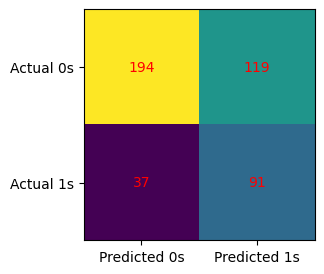

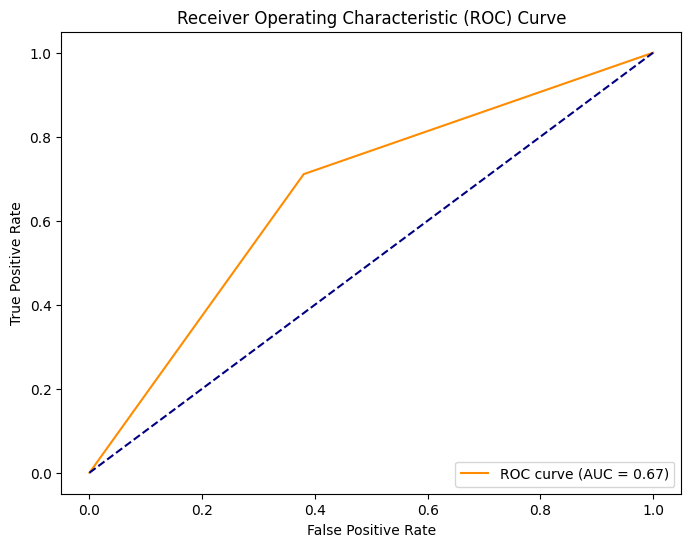

In [47]:
###################################### Get confusion matrix of test results ######################################
y_test_pred = np.round(best_model.predict(X_test_scaled))

# Calculate classification metrics
accuracy = accuracy_score(y_test, y_test_pred)
f1_macro = f1_score(y_test, y_test_pred, average='macro')
roc_auc = roc_auc_score(y_test, y_test_pred)

print("=== Classification Results for Test Set ===")
# print(f"Accuracy: {accuracy:.2f}")
# print(f"F1 Score (Macro): {f1_macro:.2f}")
print(classification_report(y_test, y_test_pred))
print(f"Area under ROC Curve (TP/FP): {roc_auc:.2f}")

cm = confusion_matrix(y_test, y_test_pred)
confusion_matrix_plot(cm)

roc_plot(y_test, y_test_pred)

so far best_model:
``` python
X = oneDs_selected_dummies.drop(columns=["userId", "id", "rating", "likeMovie", "original_language", "overview", "tagline", "title", \
    "director", "cast", "movie_title", "budget", "popularity", "average_sentiment"])
    
def create_model():
    model = keras.Sequential([
        keras.Input((num_features,)),
        layers.Dense(45, activation="relu"),
        layers.Dense(1, activation='sigmoid')
    ])
    # model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['F1Score'])
    return model

# Create a KerasClassifier based on the create_model function
model = KerasClassifier(build_fn=create_model, loss="binary_crossentropy", verbose=0, random_state=42)

param_grid = {
    'optimizer': ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam'], # 
    'epochs': [100, 125, 150],  #  
    'batch_size': [32, 64]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='f1_macro')

Best Parameters: {'batch_size': 64, 'epochs': 125, 'optimizer': 'Nadam'}
Best F1 macro: 0.6294450451951165
=== Classification Results for Test Set ===
              precision    recall  f1-score   support

       False       0.84      0.64      0.72       313
        True       0.44      0.70      0.54       128

    accuracy                           0.66       441
   macro avg       0.64      0.67      0.63       441
weighted avg       0.72      0.66      0.67       441

Area under ROC Curve (TP/FP): 0.67


```